<a href="https://colab.research.google.com/github/Eugene31415/Data_science/blob/main/Final_Project_DLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Контактная информация
####Карташев Евгений Дмитриевич
####Тема проекта: "Автоенкодеры"
####Telegram - @KevinBirdie
####mail - doggie1999@mail.ru
####vk - https://vk.com/id581086149
####User ID on Stepik.org: 18472953

#Import

In [ ]:
import matplotlib.pyplot as plt
from skimage.transform import resize
import pandas as pd
import numpy as np
import skimage.io
import random 
import copy
import os

from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import Input, Dense, Flatten, Reshape
from keras.layers.merge import concatenate as concat
from keras.utils import to_categorical
from keras.models import Model
import keras.backend as K
import keras

import tensorflow as tf

#Preparations

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs,df
    


Собрать дату и атрибуты

In [ ]:
data, attrs, df = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


Выбрать несколько картинок улыбающихся и неулыбающихся людей

In [ ]:
dx, dy, dimx, dimy = 80, 80, 64, 64
number_of_people = 20
smiling_pics = df.loc[df.Smiling > 0.7].iloc[:number_of_people]['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))
smiling_pics = np.stack(smiling_pics.values)

not_smiling_pics = df.loc[df.Smiling < -1].iloc[:number_of_people]['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))
not_smiling_pics = np.stack(not_smiling_pics.values)

Функция для отображения картинок

In [ ]:
def imshow(*args):
    sets = [x for x in args]
    print(sets[0].shape[3])
    if sets[0].shape[3] == 1:
        sets = [x.squeeze() for x in sets]
    min_size = min([len(x) for x in sets])
    plt.figure(figsize=(2*min_size, 2*len(sets)))
    for i in range(len(sets)):
        for j in range(min_size):
            plt.subplot(len(sets),min_size,j + i*min_size + 1)
            plt.imshow(sets[i][j])

Разбиваем датасет на train и val

In [ ]:
n = data.shape[0]
train_size = n*0.9
a = list(range(n))
random.shuffle(a)
train_idxs, val_idxs = np.split(a,[int(n*0.85)])
train, val = data[train_idxs], data[val_idxs]

#Модель Autoencoder

In [ ]:
encoded_dim = 1000

def create_vanila_ae():

    img = Input((64,64,3), name='img')
    
    x = Flatten()(img)
    encoded = Dense(encoded_dim, activation='linear', name='latent')(x)
    xx = Input((encoded_dim,))

    x = Dense(64*64*3, activation='sigmoid')(xx)
    x = Reshape((64,64,3))(x)

    encoder = Model(img,encoded, name='encoder')
    decoder = Model(xx,x,name='decoder')

    autoencoder = Model(img,decoder(encoder(img)),name='autoencoder')

    return encoder, decoder, autoencoder

In [ ]:
encoder, decoder, autoencoder = create_vanila_ae()
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 64, 64, 3)]       0         
_________________________________________________________________
encoder (Functional)         (None, 1000)              12289000  
_________________________________________________________________
decoder (Functional)         (None, 64, 64, 3)         12300288  
Total params: 24,589,288
Trainable params: 24,589,288
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                    loss='binary_crossentropy')

autoencoder.fit(train,train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(val,val))

3


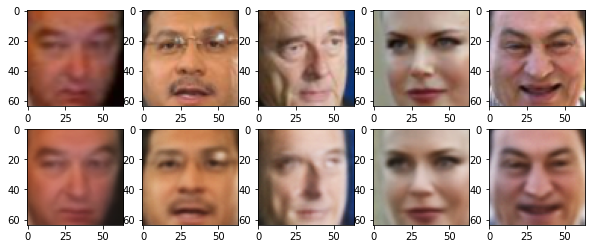

In [ ]:
imgs = val[:5]
decoded = autoencoder.predict(imgs, batch_size=5)
imshow(imgs,decoded)

Усредненный латентный вектор из 500 латентных векторов с реальных лиц

3


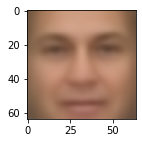

In [ ]:
# Здесь взят усредненный латентный вектор, а не произвольный, так как произвольным не удается добиться хорошего результата
imgs = val[:500]
latent = autoencoder.layers[1](imgs)
mean_latent = tf.math.reduce_mean(latent, axis=0)
mean_latent = tf.expand_dims(mean_latent,0)
pred = autoencoder.layers[2](mean_latent)

imshow(pred)

Случайный вектор

3


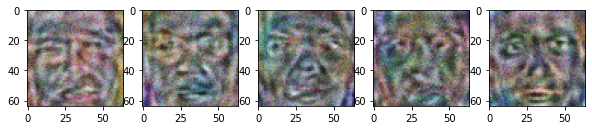

In [ ]:
# Вот к примеру то, что получается рандомными латентными векторами
vectors = np.random.randn(5, 1000)
preds = autoencoder.layers[2](vectors)
imshow(preds)

#Улыбки людям

3


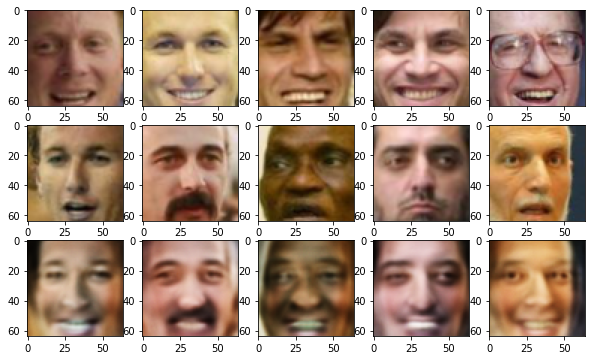

In [ ]:
# Латентный вектор улыбающихся людей
latent_smile = autoencoder.layers[1](smiling_pics)
# Латентный вектор неулыбающихся людей
latent_not_smile = autoencoder.layers[1](not_smiling_pics)
# Разница
smile_vector = tf.math.reduce_mean(latent_smile, axis=0) - tf.math.reduce_mean(latent_not_smile, axis=0)
# Пририсовывание улыбок грустному латентному вектору
make_smile_vector = 2*smile_vector + latent_not_smile # коэффициентом у smile_vector можно регулировать улыбки

preds = autoencoder.layers[2](make_smile_vector)

imshow(smiling_pics[:5], not_smiling_pics[:5], preds[:5])

#Image denoising

Добавим шум к картинкам

In [ ]:
noise_factor = 0.2
noise_train = train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train.shape) 
noise_val = val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=val.shape) 

In [ ]:
encoder_denoise, decoder_denoise, autoencoder_denoise = create_vanila_ae()

autoencoder_denoise.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                    loss='binary_crossentropy')

autoencoder_denoise.fit(noise_train,train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(noise_val,val))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3


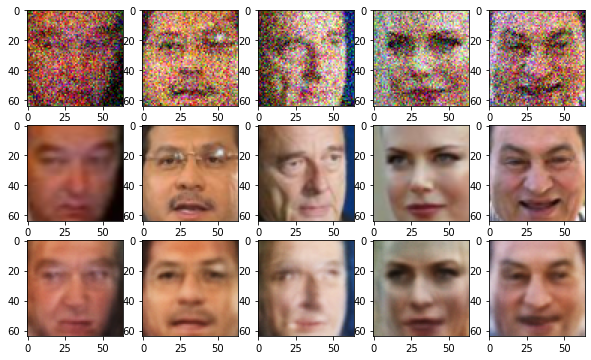

In [ ]:
noise_imgs = noise_val[:5]
clean_imgs = val[:5]
preds = autoencoder_denoise.predict(noise_imgs, batch_size=5)
imshow(noise_imgs,clean_imgs,preds)

#Occlusion

3


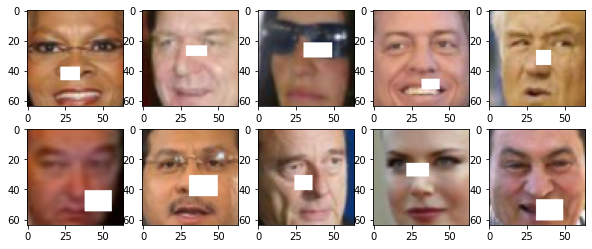

In [ ]:
train_imgs_occlusioned = copy.deepcopy(train)
val_imgs_occlusioned = copy.deepcopy(val)

# Вырезаем рандомный прямоугольник на train
for i in range(len(train)):
    dx = np.random.randint(7,15)
    dy = np.random.randint(10,20)
    a = np.random.randint(15,49)
    b = np.random.randint(20,44)
    train_imgs_occlusioned[i,a:a+dx,b:b+dy] = (1,1,1)

# Вырезаем рандомный прямоугольник на val
for i in range(len(val)):
    dx = np.random.randint(7,15)
    dy = np.random.randint(10,20)
    a = np.random.randint(15,49)
    b = np.random.randint(20,44)
    val_imgs_occlusioned[i,a:a+dx,b:b+dy] = (1,1,1)


imshow(train_imgs_occlusioned[:5], val_imgs_occlusioned[:5])

In [ ]:
encoder_occlusion, decoder_occlusion, autoencoder_occlusion = create_vanila_ae()

autoencoder_occlusion.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                    loss='binary_crossentropy')

autoencoder_occlusion.fit(train_imgs_occlusioned,train, 
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(val_imgs_occlusioned,val),verbose = 2)

3


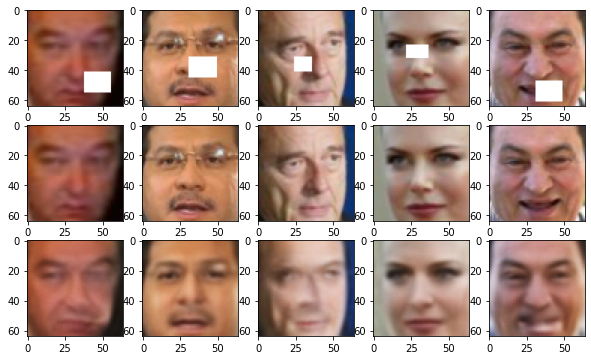

In [ ]:
clipped_imgs = val_imgs_occlusioned[:5]
clean_imgs = val[:5]
preds = autoencoder_occlusion.predict(clipped_imgs, batch_size=5)
imshow(clipped_imgs,clean_imgs,preds)

#Image Morphing

3


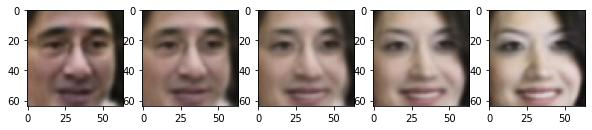

In [ ]:
# Берем 2 рандомные картинки
img_1_start = train[10]
img_2_start = train[20]
img_1 = np.expand_dims(img_1_start, 0)
img_2 = np.expand_dims(img_2_start, 0)

# Считаем латентный вектор + переход
latent_1 = autoencoder.layers[1](img_1)
latent_2 = autoencoder.layers[1](img_2)
sum_latent = np.array([(alpha * latent_1 + (1 - alpha) * latent_2).numpy() \
                        for alpha in np.linspace(0,1,5)])

morphings = autoencoder.layers[2](np.squeeze(sum_latent,1))   
imshow(morphings)
              

#Variational Autoencoder

Берем MNIST, чтобы аккуратно посмотреть на распределение в latent vector

In [ ]:
from tensorflow.keras.datasets import mnist
(train_m, train_labels_m), (val_m, val_labels_m) = mnist.load_data()

train_m = train_m.astype('float32')/255
val_m = val_m.astype('float32')/255
train_m = np.reshape(train_m, (60000, 28, 28, 1))
val_m = np.reshape(val_m, (10000, 28, 28, 1))

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
encoded_dim = 1000

class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=1.0)
        return z_mean + tf.exp(z_log_var) * epsilon

def vae_loss(x, y, mu, sigma):
    loss = keras.losses.binary_crossentropy(x, y)
    loss = tf.reduce_mean(tf.reduce_sum(loss, axis=(1, 2)))
    kl_loss = -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    return loss + kl_loss


img = Input((64,64,3), name='img')

x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(img)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = Flatten()(x)
x = Dense(2000, activation="relu")(x)
mu = Dense(encoded_dim, name="mu")(x)
sigma = Dense(encoded_dim, name="sigma")(x)
z = Sampling()([mu, sigma])

encoder = Model(img, ([z,mu,sigma]) , name='encoder')

xx = Input((encoded_dim,))

x = Dense(8*8 * 128, activation="relu")(xx)
x = Reshape((8, 8, 128))(x)
x = Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
out = Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

decoder = Model(xx,out,name='decoder')

z, mu, sigma = encoder(img)
out = decoder(z)

autoencoder_vae = Model(img, out, name='autoencoder')

autoencoder_vae.add_loss(vae_loss(img, out, mu, sigma))
autoencoder_vae.compile(loss=None, optimizer='adam')


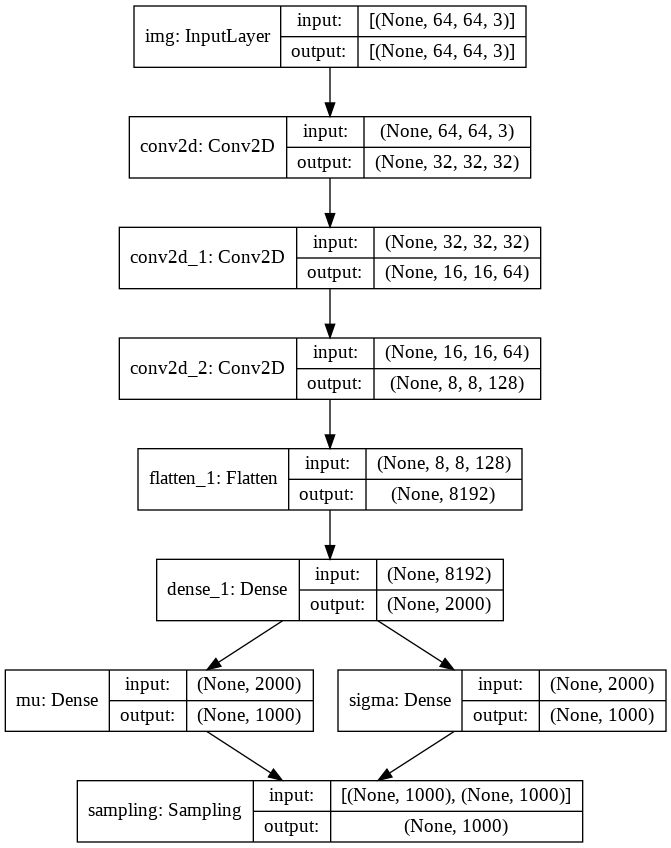

In [ ]:
keras.utils.plot_model(encoder, show_shapes=True)

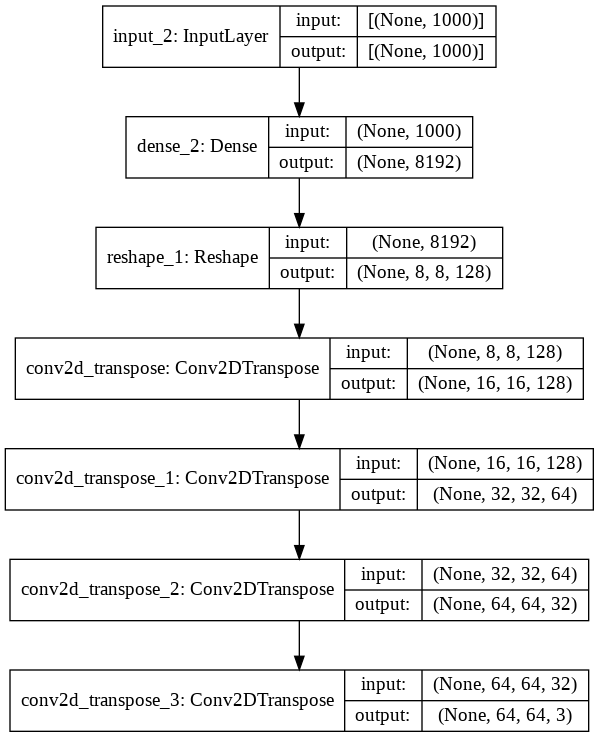

In [ ]:
keras.utils.plot_model(decoder, show_shapes=True)

In [ ]:
autoencoder_vae.fit(train,train,
                epochs=30,
                batch_size=64,
                shuffle=True,
                verbose = 2)

3


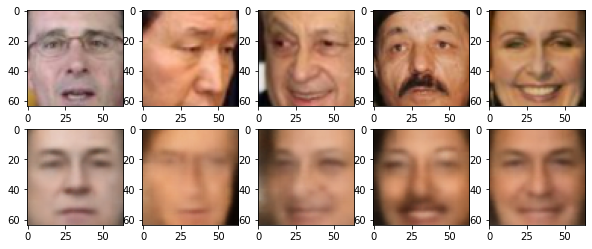

In [ ]:
imgs = val[:5]
preds = autoencoder_vae.predict(imgs, batch_size=5)
imshow(imgs, preds)

Рандомные люди

3


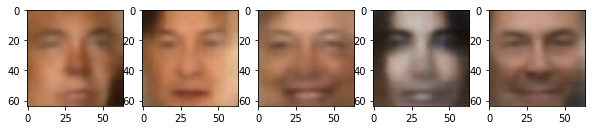

In [ ]:
vectors = np.random.randn(5, encoded_dim)
preds = autoencoder_vae.layers[2](vectors)
imshow(preds.numpy())

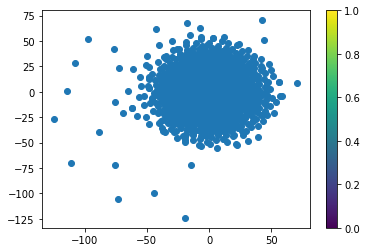

In [ ]:
from sklearn.manifold import TSNE 

dots_trained = np.array(autoencoder_vae.layers[1](val))
dots_trained_squeezed = TSNE(n_components=2).fit_transform(dots_trained[0][:1000])

plt.scatter(dots_trained_squeezed[:,0], dots_trained_squeezed[:,1])
# plt.colorbar()

#Conditional Variational Autoencoder

In [ ]:
encoded_dim = 2

class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=1.0)
        return z_mean + tf.exp(z_log_var) * epsilon

def vae_loss(x, y, mu, sigma):
    loss = keras.losses.binary_crossentropy(x, y)
    loss = tf.reduce_mean(tf.reduce_sum(loss, axis=(1,2)))
    kl_loss = -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    return loss + kl_loss


img = Input((28,28,1), name='img')
img_vec = Flatten()(img)
condition = Input((10,), name='one-hot-encoded' )

input = concat([img_vec, condition])
x = Dense(512, activation="relu")(input)
mu = Dense(encoded_dim, activation='linear')(x)
sigma = Dense(encoded_dim, activation='linear')(x)

z = Sampling()([mu, sigma])

encoder = Model([img, condition], ([z,mu,sigma]) , name='encoder')

xx1 = Input(shape=(encoded_dim,),name='latent_vector')
xx2 = Input(shape=(10,), name='condition')
dec_in = concat([xx1,xx2])

x = Dense(512, activation="relu")(dec_in)
x = Dense(784, activation="sigmoid")(x)
out = Reshape((28, 28, 1))(x)

decoder = Model([xx1,xx2], out, name='decoder')

z, mu, sigma = encoder([img,condition])
out = decoder([z,condition])

autoencoder_cvae = Model([img,condition], out, name='autoencoder')

autoencoder_cvae.add_loss(vae_loss(img, out, mu, sigma))
autoencoder_cvae.compile(loss=None, optimizer=keras.optimizers.Adam(learning_rate=1e-4))

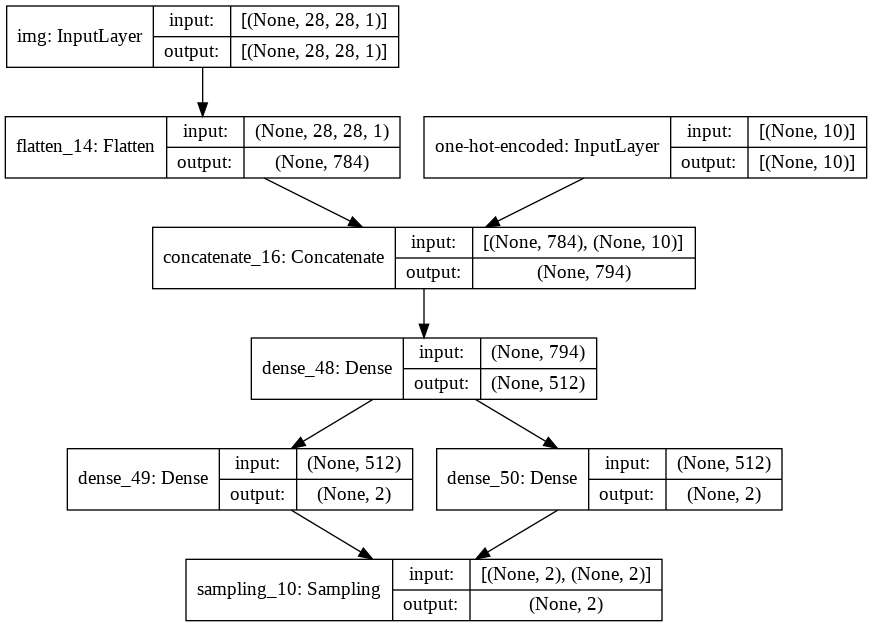

In [ ]:
keras.utils.plot_model(encoder, show_shapes=True)

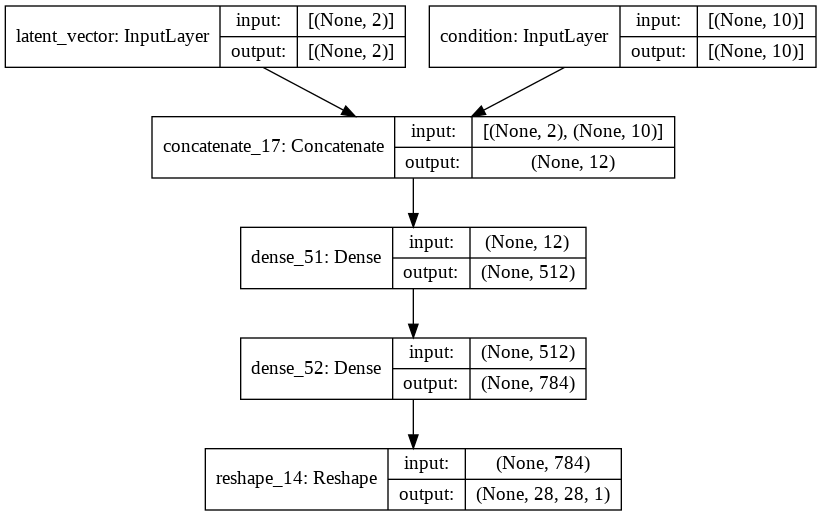

In [ ]:
keras.utils.plot_model(decoder, show_shapes=True)

In [ ]:
train_labels_m_one_hot = to_categorical(train_labels_m)
val_labels_m_one_hot = to_categorical(val_labels_m)

autoencoder_cvae.fit([train_m,train_labels_m_one_hot],train_m,
                epochs=50,
                batch_size=124,
                shuffle=True,
                verbose = 2)

Смотрим как он повторяет вход

1


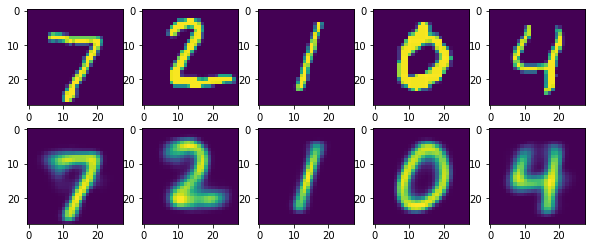

In [ ]:
imgs = val_m[:5]
labels = val_labels_m_one_hot[:5]
preds = autoencoder_cvae.predict([imgs, labels], batch_size=5)
imshow(imgs, preds)

Генерим рандомные цифры из одного случайного вектора и из разных

1


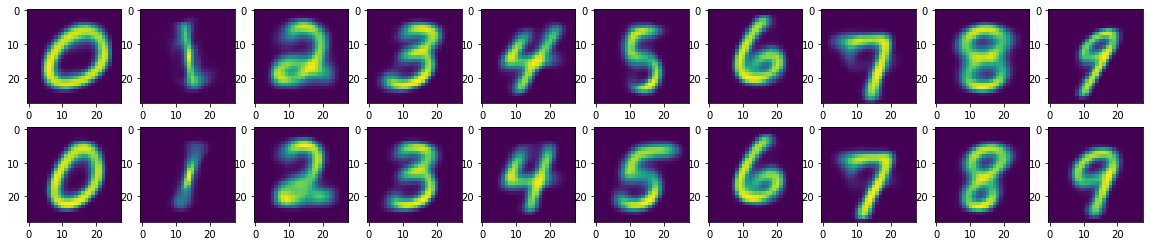

In [ ]:
unique_one_hot = to_categorical(np.arange(10))
latent_5 = np.random.randn(10,encoded_dim)
preds_different = autoencoder_cvae.get_layer(name='decoder')([latent_5, unique_one_hot])

latent_1 = np.random.randn(1,encoded_dim)
monifold = np.array([latent_1.squeeze() for _ in range(10)])

preds_same = autoencoder_cvae.get_layer(name='decoder')([monifold, unique_one_hot])

imshow(preds_different.numpy(),preds_same.numpy())

(3, 10000, 2) (1000, 2)


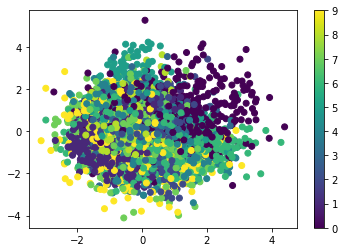

In [ ]:
# В случае, когда encoding_dim = 2 нам не нужны закоменченные строки

dots_trained = np.array(autoencoder_cvae.get_layer(name='encoder')([val_m,val_labels_m_one_hot]))
# dots_trained_squeezed = TSNE(n_components=2).fit_transform(dots_trained[0][:1000])

print(dots_trained.shape, dots_trained_squeezed.shape)

# plt.scatter(dots_trained_squeezed[:,0], dots_trained_squeezed[:,1], c= val_labels_m[:1000])
plt.scatter(dots_trained[0][:,0], dots_trained[0][:,1], c= val_labels_m)

plt.colorbar()